## Introduction
This is an introduction to using FloPy within a model-specific function. If you haven't installed Flopy, go back to the [MODFLOW and FloPy setup notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/MODFLOW%2C%20Python%2C%20and%20FloPy%20Setup.ipynb) and the [FloPy Introduction notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/FloPy%20Introduction.ipynb).

Import the standard libraries

In [1]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os
# In addition to our typical libraries
import numpy as np
import matplotlib.pyplot as plt

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy


First find where you have your MODFLOW and MT3D executables located on your system.

In [2]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Hydro\\MF2005.1_12\\MF2005.1_12\\bin\\mf2005' # Laptop
# exe_name_mf = 'C:\\Hydro\\MF2005.1_12\\bin\\mf2005' # Desktop
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# exe_name_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Hydro\MF2005.1_12\MF2005.1_12\bin\mf2005
C:\Hydro\mt3dusgs1.1.0\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


Let's use the same directory to save the data as the FloPy introduction and then create a path to this workspace. It may be useful to understand your current working directory, this should be whereever you have this notebook saved. You can double check this with the command 'os.getcwd()'.

In [3]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises\Contaminant-Hydrogeology-Activities


In [4]:
# if this is not where you want to save stuff then change your directory using 'os.chdir()'
os.chdir('C:\\Users\\zahas\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises') # laptop
# os.chdir('D:\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises') # desktop
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises


In [5]:
# directory to save data
directory_name = 'data_1D_model'
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', directory_name)

Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.


## 1D Model Function
The first thing we do is setup the function. We will use nearly identical settings as we used in the [FloPy Introduction notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/FloPy%20Introduction.ipynb) example, but now we are providing a few input variables that can be changed everytime we call the model. The input variables are:

### Function Input:
#### directory name
    direname = 

#### period length 
Time is in selected units, the model time length is the sum of this (for steady state flow it can be set to anything). The format for multi-period input: ```[60., 15*60]```
 
    perlen_mf = 
    
#### advection velocity
Note that this is only an approximate advection flow rate in due to the way that the inlet boundary conditions are being assigned in the MODFLOW BAS6 - Basic Package. More rigorous constraint of constant flux boundaries require the Flow and Head Boundary Package, the Well Package, or the Recharge Package.

    v = 
    
#### dispersivity
Set the longitudinal dispersivity in selected units. What are the units again?

    al = 
    
#### itype
An integer indicating the type of solute source condition. ```itype = -1``` corresponds to a constant concentration boundary (first-type boundary conditions in our analytical solutions) and ```itype = 1``` is equivalent to third type boundary conditions in our analytical solution.  

    itype = 
    

In [6]:
def model_1D(dirname, perlen_mf, v, al, itype):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 1 # MODFLOW
    mt_tunit = 'S' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 3 # MODFLOW units
    mt_lunit = 'CM' # MT3D units
    
    # number of stress periods (MF input), calculated from period length input
    nper = len(perlen_mf)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 100
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    nlay = 1 # number of layers
    nrow = 1 # number of rows
    ncol = 101 # number of columns
    delv = 4.4 # grid size in direction of Lz
    delc = 4.4 # grid size in direction of Ly, this was choosen such that the model has the same cross-sectional area as the column from the dispersion notebook example
    delr = 0.1 # grid size in direction of Lx
    laytyp = 0
    
    # length of model in selected units 
    Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + " (check units of 'lenuni')")
    
    # hydraulic conductivity
    hk = 1.
    # advection velocity (function input)
    # v = 0.014
    # porosity
    prsity = 0.3
    # discharge (again in selected units)
    q = v * prsity
    print("Discharge = " + str(q))
    
    # Flow field boundary conditions (variables for the BAS package)
    # boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    # index the inlet cell
    ibound[0, 0, 0] = -1
    # index the outlet cell
    ibound[0, 0, -1] = -1
    # constant head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx / hk
    # index the inlet cell
    strt[0, 0, 0] = h1
    print("head differential across column = " + str(h1) + " (check units of 'lenuni')")
    
    # Solute transport boundary conditions
    # Concentration at inlet boundary
    c0 = 1.

    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=np.int)

    # Initial conditions: initial concentration zero everywhere
    sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
    
    # Itype is an integer indicating the type of source.
    # 1 = equivalent to type 3 BCs
    # 2 = well, 3 = drain, -1 = constant concentration
    # itype = -1
    spd_mt = {0:[0, 0, 0, c0, itype]}
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # Assign name and create modflow model object
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS model object
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs)
    
    # Advection package class
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this produces minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method (HMOC)
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = -1
    # percel is the Courant number for numerical stability (≤ 1)
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=0.5)
    
    # Dispersion package class
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    # source/sink package
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    # matrix solver package, may want to add cclose=1e-6 to define the convergence criterion in terms of relative concentration
    gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1e-6)
    # write mt3dms input
    mt.write_input()
    
    # run mt3dms
    mt.run_model(silent=True)

    # Extract output
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, z, y, x)
    conc = ucnobj.get_alldata()
    
    return mf, mt, times, conc

Now lets trying running a model by calling our 'model_1D' function

In [7]:
dirname = 'run1'
perlen_mf = [30*60] 
v = 0.014
al = 2.0 # cm
# itype 1 is flow weighted solute input, itype -1 is constant concentration
itype = -1

# Call the FloPy model function
mf, mt, times, conc = model_1D(dirname, perlen_mf, v, al, itype)

.\data_1D_model\run1
Model length is: 10.1 (check units of 'lenuni')
Discharge = 0.0042
head differential across column = 0.041999999999999996 (check units of 'lenuni')


Now let's plot the model output as a function of time

Text(0.5, 0, 'Time [min]')

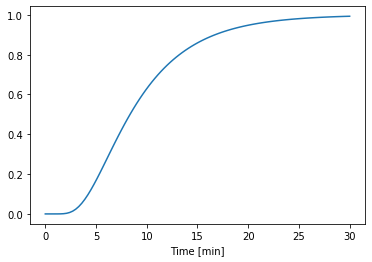

In [8]:
C_btc = conc[:, 0, 0, -1]
plt.plot(times/60, C_btc, label='Breakthrough Curve')
plt.xlabel('Time [min]')

## 1D Analytical Solution Function
Now lets compare the numerical results with the analytical solution we looked at in our previous notebook. Note the addition of the finite length outlet boundary conditions with type 1 inlet conditions (Equation A3 in van Genuchtena and Alves, 1982).

In [9]:
# Remember that we need a few special functions
from scipy.special import erfc as erfc
from scipy.special import erf as erf

# Type 1 inlet conditions, infinite solution
def analytical_model_1D_t1(x, t, v, al):
    # Dispersion
    D = v*al
    # Analytical solution: See lecture slides or (Parker and van Genuchten, 1984) for details
    # Note that the '\' means continued on the next line
    Conc_time_type1 = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t)))
    
    return Conc_time_type1

# Type 1 inlet conditions, finite length solution
def analytical_model_1D_finite_t1(x, t, v, al, L):
    # Dispersion
    D = v*al
    # Analytical solution: Analytical solution based on Equation A3 in van Genuchtena and Alves, 1982.
    # Note that the '\' means continued on the next line
    Conc_time_type1_finite = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*(2 + (v*(2*L - x)/D) + v**2*t/D)* \
        np.exp(v*L/D)*erfc(((2*L - x)+ v*t)/(2*np.sqrt(D*t))) - \
        (v**2 *t/(3.1415*D))**(1/2) * np.exp(v*L/D - ((2*L - x + v*t)**2)/(4*D*t))
            
    return Conc_time_type1_finite

# Type 3 inlet conditions, infinite solution
def analytical_model_1D_t3(x, t, v, al):
    # Dispersion
    D = v*al
    # Analytical solution: See lecture slides or (Parker and van Genuchten, 1984 eq 9b) for details
    Conc_time_type3 = (1/2)* erfc((x - v*t)/(2* np.sqrt(D*t))) + \
    np.sqrt((v**2*t)/(3.1415*D))* np.exp(-(x - v*t)**2/(4*D*t)) - \
    (1/2)*(1 + (v*x/D) + (v**2*t/D))* np.exp(v*x/D)* erfc((x + v*t)/(2* np.sqrt(D*t)))
    
    return Conc_time_type3

Call the function to calculate the breakthrough curve at outlet of the core

In [10]:
# Extract the model grid cell center location (in selected units, cm in this case)
x = mf.dis.sr.xcenter
xa = x + x[0]
print('Outlet of model: ' + str(x[-1]) + ' cm')

Outlet of model: 10.05000014975667 cm


In [11]:
# Call the analytical model function
Conc_time_type1 = analytical_model_1D_t1(x[-1], times, v, al)
Conc_time_ftype1 = analytical_model_1D_finite_t1(x[-1], times, v, al, x[-1])
Conc_time_type3 = analytical_model_1D_t3(x[-1], times, v, al)

Now let's plot a comparison.

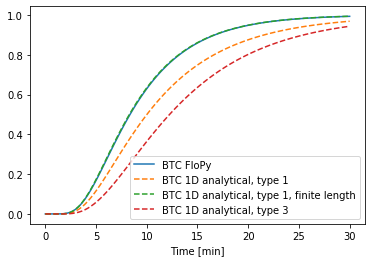

In [12]:
c1, = plt.plot(times/60, C_btc, label='BTC FloPy')
c2, = plt.plot(times/60, Conc_time_type1, '--', label='BTC 1D analytical, type 1')
c3, = plt.plot(times/60, Conc_time_ftype1, '--', label='BTC 1D analytical, type 1, finite length')
c4, = plt.plot(times/60, Conc_time_type3, '--', label='BTC 1D analytical, type 3')
plt.xlabel('Time [min]');

plt.legend(handles=[c1, c2, c3, c4])

Based on these results what is the approximate mean arrival time of the solute at the end of the core? Based on the volumetric flow rate and pore volume of the column does this arrival time make sense? Why or why not?

## Activity:
Using these code, evalute the concration profile along the column a few different times.

In [13]:
# Choose a timestep to evaluate the analytical solution at
timestep = 10
# Note that this timestep corresponds to the numerical model output increment, the actual model time is given by
print('Model time: ' + str(times[timestep]/60) + ' min')

# Call the analytical model functions
Conc_time_type1_x = analytical_model_1D_t1(x, times[timestep], v, al)
Conc_time_ftype1_x = analytical_model_1D_finite_t1(x, times[timestep], v, al, x[-1])
Conc_time_type3_x = analytical_model_1D_t3(x, times[timestep], v, al)

Model time: 3.0 min


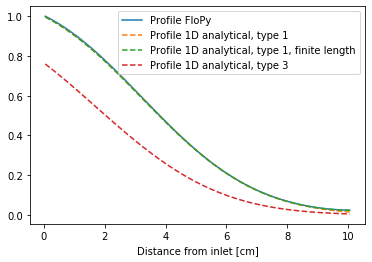

In [14]:
# Extract the concetration profile at a specific timestep
C_profile = conc[timestep, 0, 0, :]

c1, = plt.plot(x, C_profile, label='Profile FloPy')
c2, = plt.plot(x, Conc_time_type1_x, '--', label='Profile 1D analytical, type 1')
c3, = plt.plot(x, Conc_time_ftype1_x, '--', label='Profile 1D analytical, type 1, finite length')
c4, = plt.plot(x, Conc_time_type3_x, '--', label='Profile 1D analytical, type 3')
plt.xlabel('Distance from inlet [cm]')

plt.legend(handles=[c1, c2, c3, c4])

This is showing the solute front concentration as a function of space. Do we call this a concentration profile or breakthrough curve?

In [15]:
# Now repeat this for a later time
timestep = 20 # change to whatever 
print('Model time: ' + str(times[timestep]/60) + ' min')

# Call the analytical model function
# copy and paste code, work through each line to make sure you understand what each command does



Model time: 6.0 min


#### Work through the following questions:
Explain the differences between these concentration profiles at different times. 

What is the mechanism that leads to differences in solute front location? For example, if time and spatial location don't change, what will cause the green line to shift left or shift right along the x-axis?

How is the slope of the line changing at the two differnt times. Does the slope increase or decrease with time? Why?

Why does the FloPy model fit a Type 1 inlet boundary condition and not a Type 3 (hint go back and examine our ```itype``` input variable)? Do the differences between the two solutions increase or decrease with changes in dispersivity?